[-71.1497253986039, -71.7189780669156, -72.2716697408847, -72.8081030508354, -73.32857543915, -73.8333792502458, -74.3228018189379, -74.7971255572152, -75.2566280394604, -75.7015820744829, -76.1322558379512, -76.5489128722336, -76.9518122233694, -77.3412085035159, -77.7173519674951, -78.0804885878657, -78.4308601286723, -78.7687042179217, -79.0942544187504, -79.4077402993284, -79.7093875015212, -79.9994178083331, -80.278049210151, -80.5454959698194, -80.8019686865593, -81.0476743594126, -81.2828164488635, -81.5075949335676, -81.7222063751378, -81.9268439746057, -82.1216976298606, -82.3069539920729, -82.4827965211294, -82.6494055400899, -82.8069582886871, -82.9556289758878, -83.0955888315319, -83.2270061570639, -83.3500463753415, -83.4648720797084, -83.5716430820162, -83.6705164599158, -83.7616466124979, -83.8451852708577, -83.9212815929555, -83.9900821760942, -84.05173110765, -84.1063700076076, -84.1541380703577, -84.1951721057657, -84.2296065795245, -84.2575736528147, -84.279203221266

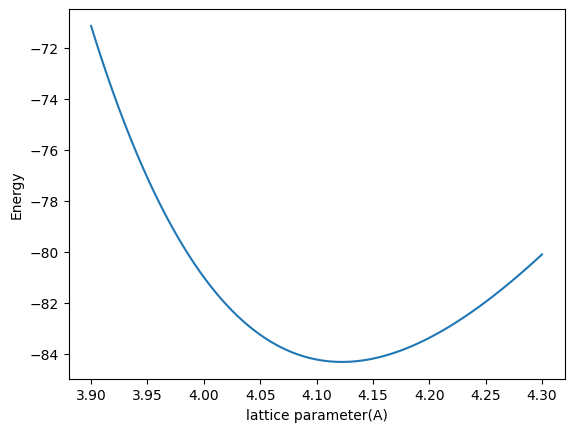

In [3]:
from labutil.plugins.lammps import lammps_run, get_lammps_energy
from labutil.objects import Struc, Dir, ClassicalPotential, ase2struc
from ase.spacegroup import crystal
from ase.build import make_supercell
import numpy, os
import matplotlib.pyplot as plt


input_template = """
# ---------- 1. Initialize simulation ---------------------
units metal
atom_style atomic
dimension  3
boundary   p p p
read_data $DATAINPUT

# ---------- 2. Specify interatomic potential ---------------------
#pair_style eam/alloy
#pair_coeff * * $POTENTIAL  Al

pair_style lj/cut 4.5
pair_coeff 1 1 0.392 2.620 4.5

# ---------- 3. Run single point calculation  ---------------------
thermo_style custom step pe lx ly lz press pxx pyy pzz
run 0

#fix 1 all box/relax iso 0.0 vmax 0.001

#min_style cg
#minimize 1e-10 1e-10 1000 10000

# ---- 4. Define and print useful variables -------------
variable natoms equal "count(all)"
variable totenergy equal "pe"
variable length equal "lx"

print "Total energy (eV) = ${totenergy}"
print "Number of atoms = ${natoms}"
print "Lattice constant (Angstoms) = ${length}"
"""


def make_struc(alat):
    """
    Creates the crystal structure using ASE.
    :param alat: Lattice parameter in angstrom
    :return: structure object converted from ase
    """
    unitcell = crystal(
        "Al", [(0, 0, 0)], spacegroup=225, cellpar=[alat, alat, alat, 90, 90, 90]
    )
    multiplier = numpy.identity(3) * 2
    ase_supercell = make_supercell(unitcell, multiplier)
    
    #remove an atom
#     for i, atm_nm in enumerate(ase_supercell.get_atomic_numbers()):
#         if atm_nm == 1:
#             index_to_remove = i
#             break
#     ase_supercell.pop(2)

    #structure = Struc(ase2struc(unitcell))
    structure = Struc(ase2struc(ase_supercell))
    return structure


def compute_energy(alat, template):
    """
    Make an input template and select potential and structure, and the path where to run
    """
    potpath = os.path.join(os.environ["LAMMPS_POTENTIALS"], "Al_zhou.eam.alloy")
    potential = ClassicalPotential(path=potpath, ptype="eam", element=["Al"])
    runpath = Dir(path=os.path.join(os.environ["WORKDIR"], "Lab1", str(alat)))
    struc = make_struc(alat=alat)
    output_file = lammps_run(
        struc=struc,
        runpath=runpath,
        potential=potential,
        intemplate=template,
        inparam={},
    )
    energy, lattice = get_lammps_energy(outfile=output_file)
    return energy, lattice


def lattice_scan():
    alat_list = numpy.linspace(4.0, 4.3, 100)
    #alat_list = numpy.array([] )
    
    energy_list = [
        compute_energy(alat=a, template=input_template)[0] for a in alat_list
    ]
    print(energy_list)

    plt.plot(alat_list, energy_list)
    plt.xlabel('lattice parameter(A)')
    plt.ylabel('Energy')
    plt.show()


if __name__ == "__main__":
    # put here the function that you actually want to run
    lattice_scan()
